In [1]:
import librosa
from ipywidgets import Audio
import IPython.display
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
import numpy as np
import scipy
import matplotlib.pyplot as plt
import soundfile as sf
import torch
from tqdm.notebook import tqdm
from functools import partial

from gfm_iaif import gfm_iaif
from utils import h1h2, weighted_log_mag_mse_loss
from tract_proxy import VocalTractProxy
from optimize import TractControlsOptimizer
from glottis import Glottis

# from dask.distributed import LocalCluster

In [253]:
output_notebook()

Loading BokehJS ...

In [3]:
pwd

'/Users/fcucchietti/Code/ICHOIR/vocal-tract-grad'

In [262]:
# input, fs = librosa.load("C#2.wav")
# Audio.from_file("C#2.wav", loop=False)
input, fs = librosa.load("C2.wav")  #("0_47.wav")
IPython.display.Audio(data=input, rate=fs, autoplay=True)

In [263]:
framelength = 1024
hoplength = 128
fmin, fmax = 70, 500
ncilinders = 44

In [264]:
frames = librosa.util.frame(input, frame_length=framelength, hop_length=hoplength)
nframes = frames.shape[1]

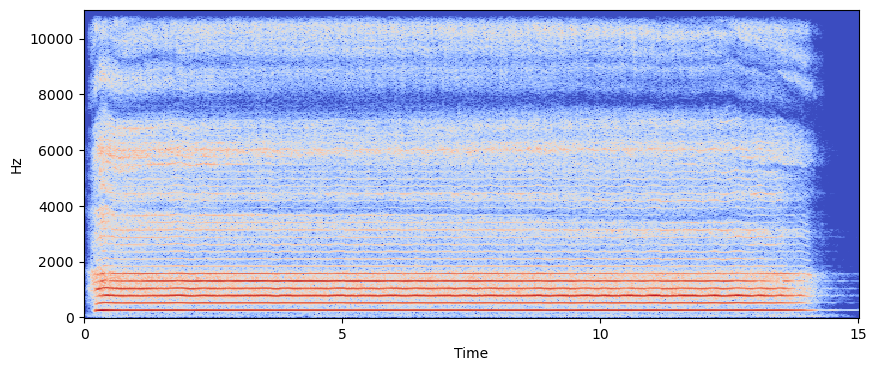

In [265]:
X = librosa.amplitude_to_db(np.abs(librosa.stft(input, n_fft=framelength))).squeeze()
plt.figure(figsize=(10,4))
librosa.display.specshow(X, sr=fs, x_axis="time", y_axis="hz")

In [266]:
f0 = np.concatenate([librosa.yin(frames[:,i] / np.max(np.abs(frames[:,i])), fmin=fmin, fmax=fmax, frame_length=framelength, hop_length=hoplength, sr=fs, center=False, trough_threshold=0.1) for i in range(nframes)])
plot = figure(title="Estimated f0", x_axis_label="Frame", y_axis_label="Frequency (Hz)", width=800, height=400)
plot.line(np.arange(f0.size), f0)
show(plot)

### Inverse filtering with GFM-IAIF

In [267]:
vtcoeffs = np.empty((ncilinders+1,nframes))
glcoeffs = np.empty((4, nframes))
lipcoeffs = np.empty((2, nframes))

glottis_iaif = np.zeros_like(input)
for i in range(nframes):
    frame = frames[:, i]
    vtcoeffs[:,i], glcoeffs[:,i], lipcoeffs[:,i] = gfm_iaif(frame, n_vt=ncilinders)
    framepad = np.pad(frame, ((0,ncilinders+1)), mode='edge')
    idx = np.arange(librosa.frames_to_samples(i, hop_length=hoplength), librosa.frames_to_samples(i, hop_length=hoplength)+framelength)
    glottis_iaif[idx] += scipy.signal.lfilter(vtcoeffs[:,i], [1], framepad)[ncilinders+1:] * scipy.signal.get_window("hamming", framelength)

IPython.display.Audio(data=glottis_iaif.T.flatten(), rate=fs,autoplay=True)

In [278]:
# probamos a recomponer la señal con el filtro inverso
glottis_ff = np.zeros_like(input)
adjcoeffs = vtcoeffs.copy()
adjcoeffs /= 100
for i in range(nframes):
    idx = np.arange(librosa.frames_to_samples(i, hop_length=hoplength), librosa.frames_to_samples(i, hop_length=hoplength)+framelength)
    frame = glottis_iaif[idx]
    framepad = np.pad(frame, ((0,ncilinders+1)), mode='edge')
    glottis_ff[idx] += scipy.signal.lfilter([1],adjcoeffs[:,i],framepad)[ncilinders+1:] * scipy.signal.get_window("hamming", framelength)

IPython.display.Audio(data=glottis_ff.T.flatten(), rate=fs,autoplay=True)

In [355]:
poles = np.roots(glcoeffs[:,650])
poles = np.array([r for r in poles if np.imag(r) >= 0])
np.arctan2(poles.imag, poles.real) * (fs / (2 * np.pi))


array([290.23978019,   0.        ])

In [431]:
glcoeffs[:,650], adjcoeffs

(array([ 1.        , -2.57320411,  2.1703317 , -0.59442655]),
 [1.0, -2.566517787975506, 2.1662044195153154, -0.5944265468645562])

In [475]:
# probamos a recomponer la señal deformando la glottis
glottis_defor = np.zeros_like(input)
no_glottis = np.zeros_like(input)
adjcoeffs = glcoeffs.copy()
#adjcoeffs[1:,650:] *= 0.9
adjcoeffs = [A*a3, A*a2, A*a1, A]
for i in range(nframes):
    frame = frames[:, i]
    framepad = np.pad(frame, ((0,ncilinders+1)), mode='edge')
    idx = np.arange(librosa.frames_to_samples(i, hop_length=hoplength), librosa.frames_to_samples(i, hop_length=hoplength)+framelength)
    no_glottis[idx] += scipy.signal.lfilter(   glcoeffs[:,i], [1], framepad)[ncilinders+1:] * scipy.signal.get_window("hamming", framelength)
    frame2 = no_glottis[idx]
    framepad2 = np.pad(frame2, ((0,ncilinders+1)), mode='edge')    
    if i>200:
        glottis_defor[idx] += scipy.signal.lfilter([1], adjcoeffs, framepad2)[ncilinders+1:] * scipy.signal.get_window("hamming", framelength)
    else:
        glottis_defor[idx] += scipy.signal.lfilter([1], glcoeffs[:,i], framepad2)[ncilinders+1:] * scipy.signal.get_window("hamming", framelength)
print(adjcoeffs)
IPython.display.Audio(data=glottis_defor.T.flatten(), rate=fs,autoplay=True)

[1.0, -2.559204594620096, 2.161690187592325, -0.5944265468645561]


In [461]:
IPython.display.Audio(data=input, rate=fs, autoplay=True)

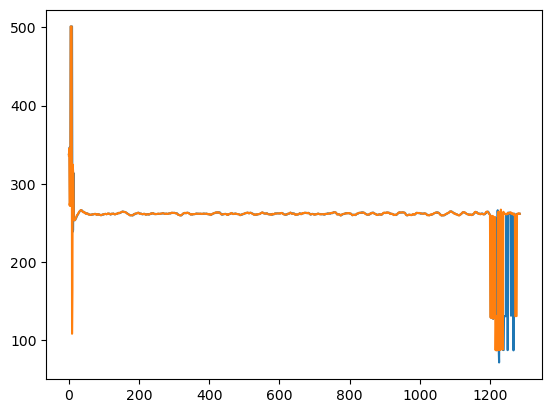

In [467]:
def_frames = librosa.util.frame(glottis_defor.T.flatten(), frame_length=framelength, hop_length=hoplength)
def_nframes = def_frames.shape[1]
def_f0 = np.concatenate([librosa.yin(def_frames[:,i] / np.max(np.abs(def_frames[:,i])), fmin=fmin, fmax=fmax, frame_length=framelength, hop_length=hoplength, sr=fs, center=False, trough_threshold=0.1) for i in range(def_nframes)])
plt.plot(f0)
plt.plot(def_f0)
plt.show()

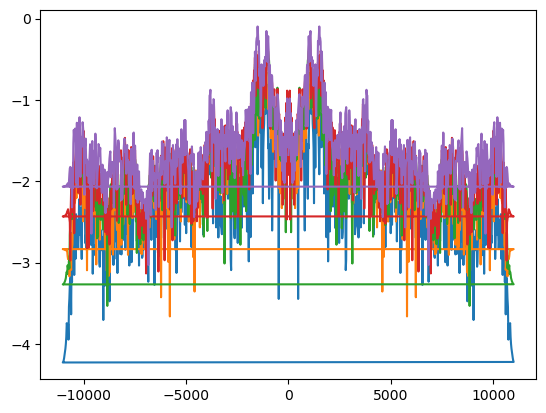

In [260]:

for i in range(5):
    d=scipy.fft.fft(frames[:,i])
    plt.plot(scipy.fft.fftfreq(1024)*fs,np.log10(np.abs(d)))
plt.show()

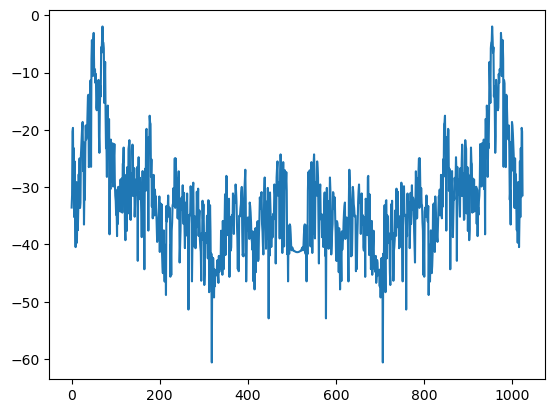

In [79]:
plt.plot( 20. * np.log10(np.abs(d)) )

In [368]:
np.roots(glcoeffs[:,650])

array([0.97796589+0.08106692j, 0.97796589-0.08106692j,
       0.61727233+0.j        ])

In [ ]:
(z-x1)*(z-x1')*(z-x2)
(z^2-z*x1-z*x1'+|x1|^2)*(z-x2)        
z^3-z^2*x1-z^2*x1'+z*|x1|^2-x2*z^2+z*x2*x1+z*x1'*x2-x2*|x1|^2
-x2*|x1|^2 + z ( |x1|^2+x2* (x1+x1') ) - z^2* (x2+x1+x1') + z^3

In [409]:
x1, x1c, x2 = np.roots(glcoeffs[:,650])
A= -np.real(x2*x1*x1c)
a1 = np.real( (x1*x1c+x2*(x1+x1c))/A)
a2 = np.real( -(x2+x1+x1c)/A)
a3 = np.real( 1/A)
A, A*a1, A*a2, A*a3, glcoeffs[:,650]

(-0.5944265468645562,
 2.1703317041091683,
 -2.573204114859584,
 1.0,
 array([ 1.        , -2.57320411,  2.1703317 , -0.59442655]))

In [413]:
poles=np.roots([A*a3, A*a2, A*a1, A])
poles

array([0.97796589+0.08106692j, 0.97796589-0.08106692j,
       0.61727233+0.j        ])

In [463]:
shift=220 *(2*np.pi)/fs
poles = np.roots(glcoeffs[:,650])
poles = np.array([poles[0]*np.exp(shift*1j),poles[1]*np.exp(-shift*1j),poles[2]])
poles, np.arctan2(poles.imag, poles.real) * (fs / (2 * np.pi))

(array([0.97096613+0.14217561j, 0.97096613-0.14217561j,
        0.61727233+0.j        ]),
 array([ 510.23978019, -510.23978019,    0.        ]))

In [464]:
x1, x1c, x2 = poles
A= -np.real(x2*x1*x1c)
a1 = np.real( (x1*x1c+x2*(x1+x1c))/A)
a2 = np.real( -(x2+x1+x1c)/A)
a3 = np.real( 1/A)
A, A*a1, A*a2, A*a3, glcoeffs[:,650]

(-0.5944265468645561,
 2.161690187592325,
 -2.559204594620096,
 1.0,
 array([ 1.        , -2.57320411,  2.1703317 , -0.59442655]))

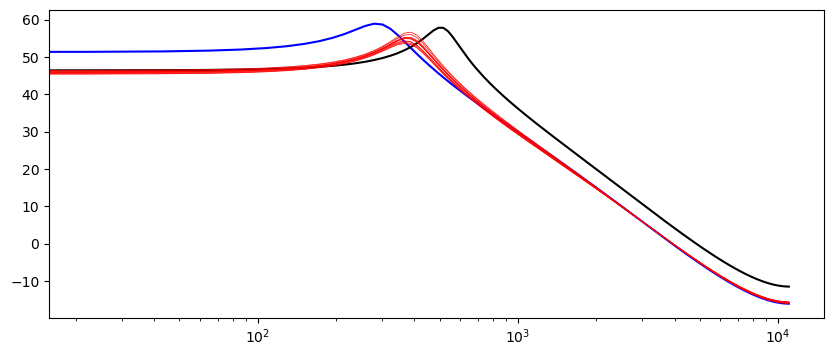

In [465]:
#plot = figure(title="Frequency response of vocal tract", width=800, height=400, 
#              x_axis_label="Frequency (Hz)", y_axis_label="Magnitude (dB)")
freqresp = np.empty((framelength//2, nframes), dtype=np.complex64)
adjcoeffs=glcoeffs.copy()
w, ref = scipy.signal.freqz([1], glcoeffs[:,600])
plt.figure(figsize=(10,4))
plt.plot(w*fs/(2*3.1416), 20. * np.log10(np.abs(ref)), c='blue')

Ag=25
Fg=290
Bg=100
#b1 = -Ag
#b2 = Ag
#a1=-2*np.exp(-np.pi*Bg/fs)*np.cos(2*np.pi*Fg/fs)
#a2=np.exp(-2*np.pi*Bg/fs)
w, ref = scipy.signal.freqz([1/A],[A*a3, A*a2, A*a1, A])
plt.plot(w*fs/(2*3.1416), 20. * np.log10(np.abs(ref)), c='black')

for i in range(-10,0):
    #adjcoeffs[1,600+i] = glcoeffs[1,600] * ((1+0.1*i/10))
    adjcoeffs[1:,600+i] /= 1.002
    w, freqresp[:,i] = scipy.signal.freqz([1], adjcoeffs[:,600+i])
    plt.plot(w*fs/(2*3.1416), 20. * np.log10(np.abs(freqresp[:,i])), c='red',linewidth=0.5)
plt.semilogx()
plt.show()

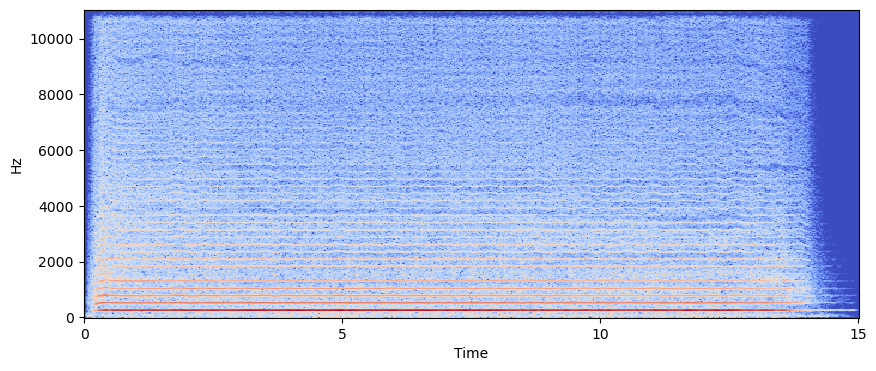

In [82]:
X = librosa.amplitude_to_db(np.abs(librosa.stft(glottis_iaif, n_fft=framelength))).squeeze()
plt.figure(figsize=(10,4))
librosa.display.specshow(X, sr=fs, x_axis="time", y_axis="hz")

### Tenseness & Loudness

In [83]:
gframes = librosa.util.frame(glottis_iaif, frame_length=framelength, hop_length=hoplength)

In [84]:
# Rd = torch.tensor((h1h2(gframes, f0, sr=fs) + 7.6) / 11.1)
Rd = np.empty(nframes)
for i in range(nframes):
    X = librosa.amplitude_to_db(np.abs(librosa.stft(gframes[:,i], n_fft=framelength, hop_length=framelength)))
    h1bin = int(np.round(f0[i] / fs * framelength))
    h2bin = int(np.round(2 * f0[i] / fs * framelength))
    Rd[i] = (X[h1bin,1] - X[h2bin,1] + 7.6) / 11.


In [187]:
tenseness = np.clip(1 - Rd / 3, 0, 1)
plot = figure(title="Tenseness", width=800, height=400, x_axis_label="Frame")
plot.line(np.arange(nframes), tenseness)
show(plot)

In [97]:
loudness = librosa.feature.rms(y=input, frame_length=framelength, hop_length=hoplength)
plot = figure(title="Loudness", width=800, height=400, x_axis_label="Frame")
plot.line(np.arange(nframes), librosa.amplitude_to_db(loudness.T.flatten()))
show(plot)

In [191]:
tenseness[:]*=0.6

In [101]:
f0[:]=260

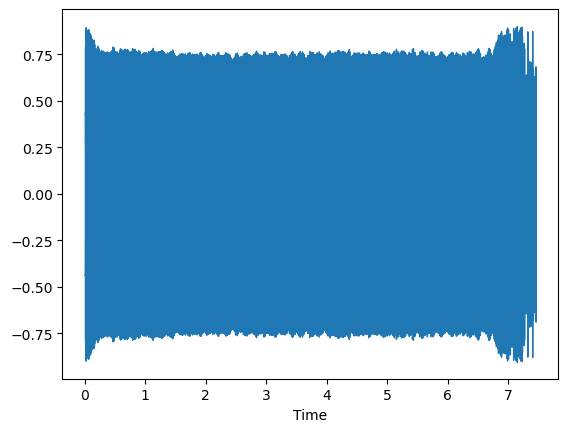

In [192]:
tenseness[:]*=0.6
glottis = Glottis(ncilinders, fs)
glottis_signal = glottis.get_waveform(tenseness=torch.Tensor(tenseness), freq=torch.Tensor(f0.reshape(-1, 1)), frame_len=hoplength).detach().numpy()
gframes = librosa.util.frame(glottis_signal, frame_length=framelength, hop_length=hoplength).copy()

librosa.display.waveshow(glottis_signal)
IPython.display.Audio(data=glottis_signal, rate=fs, autoplay=True)

## Curve fitting

In [ ]:
# plot = figure(title="Frequency Response of the Fitted Vocal Tract", width=800, height=400, x_axis_label="Frequency (Hz)", y_axis_label="Magnitude (dB)")

# vt = VocalTractProxy(framelength // 2)

# # damp glottis-lips stationary wave
# vt.r0 = 0.1
# vt.rl = -0.85
# vt.tl = 1 + vt.rl

# vtopt = TractControlsOptimizer(vt)
# Hkl = np.empty((framelength // 2, nframes), dtype=np.complex64)


# # for i in tqdm(range(nframes)):
# for i in tqdm(range(nframes)):
#     target = torch.tensor(freqresp[:,i], dtype=torch.complex64)

#     vtopt.optimize(target, loss_fn=partial(weighted_log_mag_mse_loss, sr=fs), n_iters=20)

#     Hkl[:,i] = vtopt.get_prediction().detach().numpy()

#     plot.line(np.linspace(0, fs // 2, Hkl[:,i].size), librosa.amplitude_to_db(np.abs(freqresp[:,i])), alpha=0.05, color="red")
#     plot.line(np.linspace(0, fs // 2, Hkl[:,i].size), librosa.amplitude_to_db(np.abs(Hkl[:,i])), alpha=0.05)

# show(plot)

In [ ]:
# out = np.zeros_like(input)

# for i in tqdm(range(min(nframes, gframes.shape[1]))):
#     frame = gframes[:, i]
#     framepad = np.pad(frame, ((0,ncilinders+1)), mode='edge')
#     idx = np.arange(librosa.frames_to_samples(i, hop_length=hoplength), librosa.frames_to_samples(i, hop_length=hoplength)+framelength)
#     out[idx] += np.fft.irfft(np.fft.rfft(frame * scipy.signal.get_window("hamming", framelength))[0:-1] * Hkl[:,i], n=framelength)

# out = np.nan_to_num(out, nan=0.0)

# IPython.display.Audio(data=out, rate=fs)

  0%|          | 0/1278 [00:00<?, ?it/s]

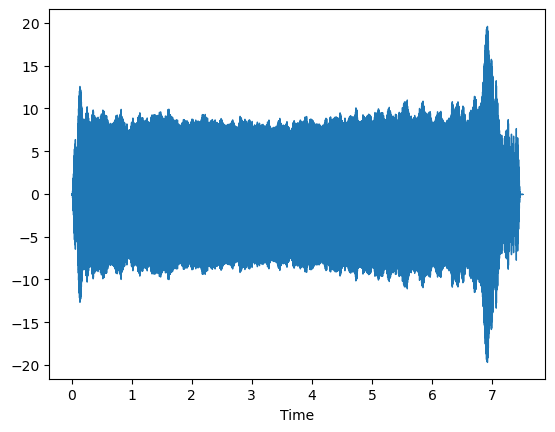

In [198]:
tenseness[:]*=0.1
glottis = Glottis(ncilinders, fs)
glottis_signal = glottis.get_waveform(tenseness=torch.Tensor(tenseness), freq=torch.Tensor(f0.reshape(-1, 1)), frame_len=hoplength).detach().numpy()

gframes = librosa.util.frame(glottis_signal, frame_length=framelength, hop_length=hoplength)

out = np.zeros_like(input)

for i in tqdm(range(min(nframes, gframes.shape[1]))):
    frame = gframes[:, i]
    framepad = np.pad(frame, ((0,ncilinders+1)), mode='edge')
    idx = np.arange(librosa.frames_to_samples(i, hop_length=hoplength), librosa.frames_to_samples(i, hop_length=hoplength)+framelength)
    # out[idx] += np.fft.irfft(np.fft.rfft(frame * scipy.signal.get_window("hamming", framelength))[0:-1] * Hkl[:,i], n=framelength)
    out[idx] += scipy.signal.lfilter([1], vtcoeffs[:,i], framepad)[ncilinders+1:] * scipy.signal.get_window("hamming", framelength)

out = np.nan_to_num(out, nan=0.0)
librosa.display.waveshow(out)

IPython.display.Audio(data=out, rate=fs, autoplay=True)

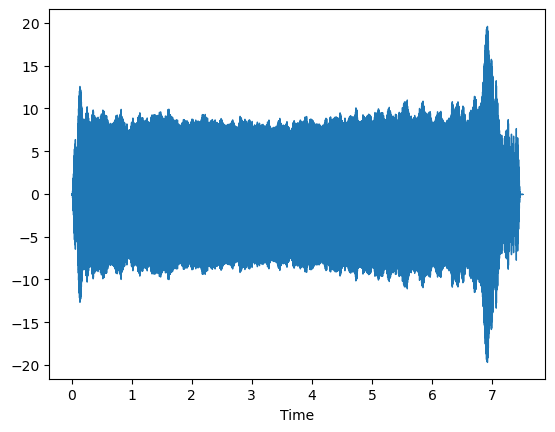

In [199]:
librosa.display.waveshow(out)

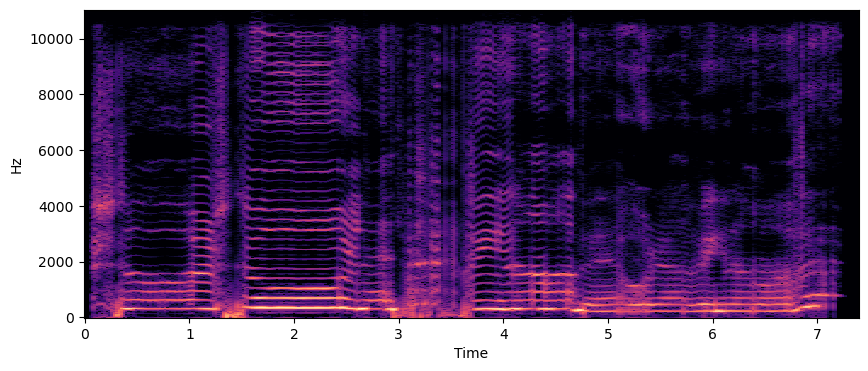

In [30]:
X = librosa.amplitude_to_db(np.abs(librosa.stft(out, n_fft=framelength))).squeeze()
plt.figure(figsize=(10,4))
librosa.display.specshow(X, sr=fs, x_axis="time", y_axis="hz")